In [285]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import tqdm
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

import src

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [287]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [288]:
expLabels = [
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
    'Test 22',
    'Test 23',
]

exps = [src.load(label) for label in expLabels]

In [289]:
# Add two features for the 350-360 kHz and 900-910 kHz frequency bands

freq = [35, 90]
# freq = list(range(0, 100))

for i, exp in enumerate(exps):
    f = np.array(exp.ae.fft[1000])
    # avg over 10kHz
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T
    for fr in freq: 
        fNew = np.concatenate(([np.NaN], f[fr]))
        exp.features[f'Freq {fr * 10} kHz'] = fNew

In [290]:
exp.features.head()

,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius,Peak radius,Radius diff,Runout,Form error,Avg probe,Probe diff,Freq 350 kHz,Freq 900 kHz
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.659884,0.675501,NaN,0.025494,0.027365,0.0000,0.0000,NaN,NaN
1,0.635682,12.791680,11.192291,-0.042766,14.634667,63.876165,44.653742,0.658784,0.674232,-0.001100,0.026484,0.028520,0.0158,0.0158,19.075560,-12.292866
2,0.844497,9.419706,13.994828,-0.111183,16.194616,68.696668,45.381555,0.658447,0.673943,-0.000336,0.026684,0.028574,0.0423,0.0265,19.431349,-13.004056
3,0.785941,7.472732,8.681134,-0.043458,16.583143,67.167170,46.369666,0.658104,0.673824,-0.000343,0.026649,0.028768,0.0752,0.0329,20.518743,-13.209046
4,0.774868,7.200813,8.143903,-0.033251,16.554227,66.827370,46.762655,0.658670,0.672988,0.000566,0.024805,0.026054,0.1038,0.0286,20.913086,-13.492828


In [291]:
doc = 0.03    # Depth of cut (mm)
tol = 0.0015   # Tolerance (mm)
# tol = 0.002   # Tolerance (mm)
overall_tol = 0.02 # Overall tolerance (mm)

In [292]:
dfs = [exp.features.copy() for exp in exps]

# Smoothing probe data
win = 11

for i, df in enumerate(dfs):
    df.loc[0, 'Probe diff'] = np.NaN
    df.loc[1:, 'Probe diff'] = _smooth(df.loc[1:, 'Probe diff'], win=win)

C:\Users\tomje\AppData\Local\Temp\ipykernel_52644\293677219.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  start = np.cumsum(sig[:win - 1])[::2] / r
C:\Users\tomje\AppData\Local\Temp\ipykernel_52644\293677219.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]


## Multiclass Labelling

In [334]:
crossings = []

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)

    crossing = []
    for ix in x[tol_bool]:
       
        if ix - 1 not in x[tol_bool]:
            crossing.append(ix)
        elif ix + 1 not in x[tol_bool]:
            crossing.append(ix)

    crossing = [crossing[1], crossing[-2]]
    crossings.append(crossing)

In [335]:
# test 8 has no wear in stage
crossings[7][0] = 0

In [336]:
crossings

[[6, 119],
 [6, 101],
 [6, 133],
 [6, 123],
 [6, 122],
 [6, 119],
 [4, 118],
 [0, 94],
 [2, 80],
 [6, 76]]

In [337]:
# Multi-class classification
categories = []
for df, cr in zip(dfs, crossings):
    categories.append(np.ones(len(df), dtype=int))
    categories[-1][:cr[0] + 1] = 0
    categories[-1][cr[1]:] = 2
    df['Probe class'] = categories[-1]

c:\Users\tomje\.conda\envs\tf\lib\site-packages\mplcursors\_pick_info.py:55: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  paths = scatter.__wrapped__(*args, **kwargs)


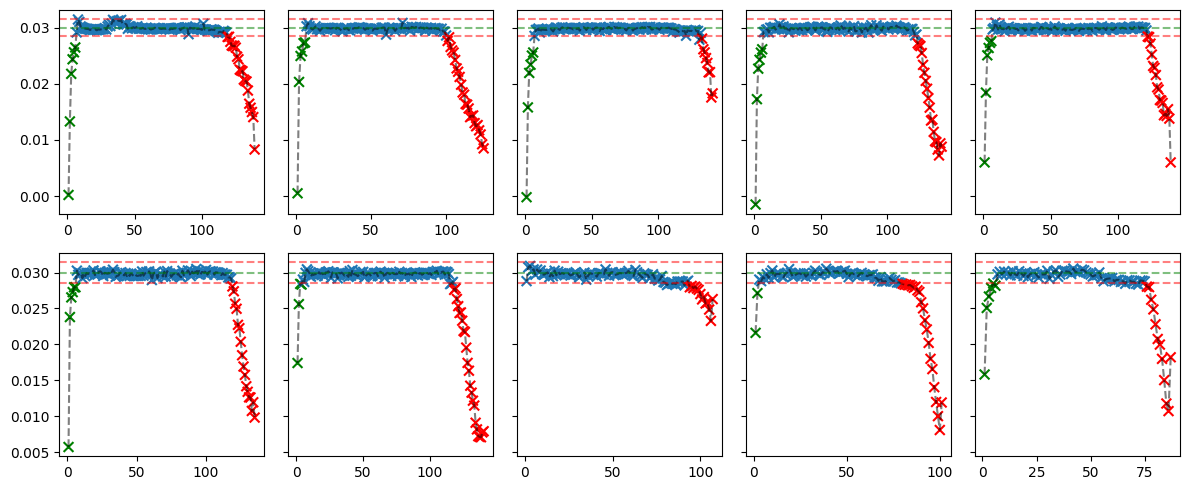

In [338]:
# scatter plot with color coding for classes
fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == 0 else 'r' if x == 2 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## Binary Classification

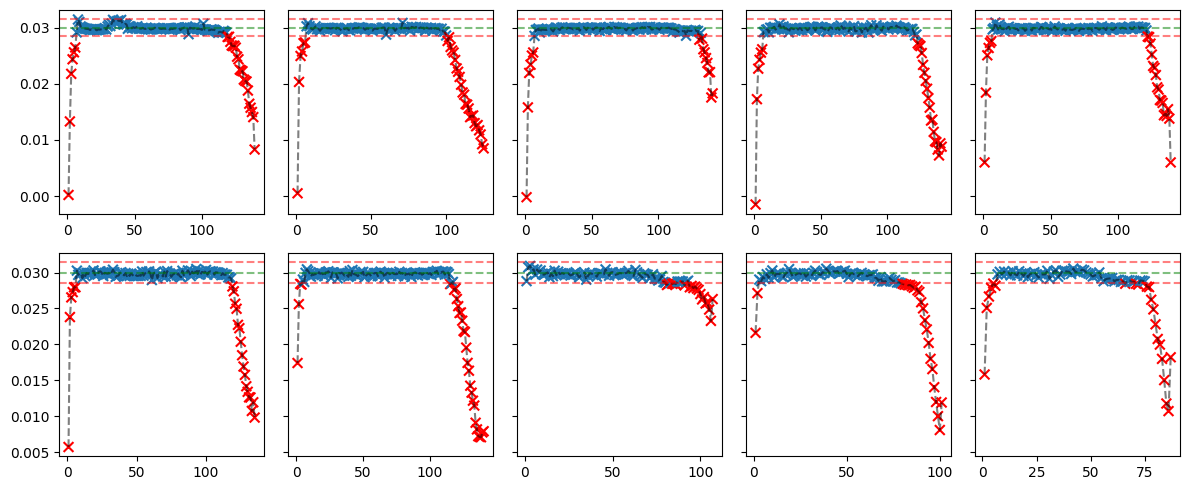

In [298]:
categories = []

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    # within tolerance band
    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y]
    tol_bool = np.array(tol_bool).astype(bool)
    categories.append(tol_bool)

for df, cat in zip(dfs, categories):
    df['Probe class'] = cat 

# scatter plot with color coding for classes
fig, ax = plt.subplots(2, 5, figsize=(12, 5), sharey='row')
ax = ax.ravel()

for i, df in enumerate(dfs):
    y = df['Probe diff']
    x = np.arange(len(y))

    ax[i].plot(x, y, color='k', alpha=0.5, linestyle='--')

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)

    c = ['g' if x == -1 else 'r' if x == 1 else 'C0' for x in df['Probe class']]
    ax[i].scatter(x, y, c=c, cmap='coolwarm', marker='x', s=50)
fig.tight_layout()

## Data Setup

In [340]:
input_dfs = []
target_dfs = []
for df in dfs:
    df = df.dropna().reset_index(drop=True)
    # x = df.iloc[:, 4:]
    x = df.drop(columns=['Runout',
                         'Form error',
                         'Peak radius',
                         'Mean radius',
                         'Radius diff',
                         'Avg probe',
                         'Probe diff',
                         'Probe class',
                         ])
    cols = x.columns
    x = StandardScaler().fit_transform(x)
    input_dfs.append(pd.DataFrame(x, columns=cols))
                                      
    y = df[['Probe class',
            'Mean radius',
            'Runout',
            'Probe diff',
            ]]
    target_dfs.append(y)


In [341]:
# Join all exp dataframes
input_df = pd.concat(input_dfs, ignore_index=True)
print(f'Input DF: {input_df.shape}')
input_df.head()

Input DF: (1255, 9)


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Freq 350 kHz,Freq 900 kHz
0,-6.681300,5.937810,-2.903966,-0.001607,-5.018532,-7.266338,-8.689190,-9.920097,-7.129147
1,-4.830036,3.940252,-0.251573,0.649762,-3.341573,-3.255199,-2.392800,-2.048943,-3.426504
2,-1.650050,1.164998,-0.693839,-1.814215,-0.450069,-0.704852,-0.275901,0.565056,0.877534
3,0.042237,0.553310,0.023348,-1.661354,-1.177280,0.423995,0.101363,0.898956,1.734818
4,0.228315,0.513910,-0.255674,-1.467125,-1.728741,0.396536,0.019825,0.666807,0.760188


In [342]:
target_df = pd.concat(target_dfs, ignore_index=True)
print(f'Target DF: {target_df.shape}')
target_df.head()

Target DF: (1255, 4)


,Probe class,Mean radius,Runout,Probe diff
0,0,0.672499,0.009005,0.000200
1,0,0.671830,0.007593,0.013300
2,0,0.669854,0.007130,0.021780
3,0,0.668865,0.007446,0.024371
4,0,0.668145,0.007160,0.025611


In [343]:
pca = PCA().fit(input_df.values)
X_pca = pca.transform(input_df.values)

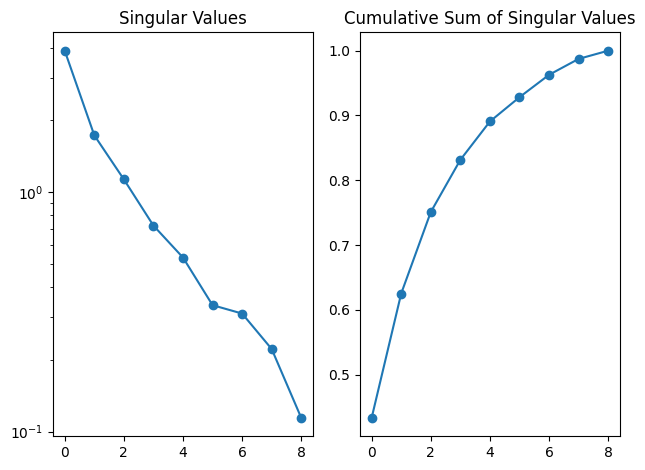

In [344]:
fig, ax = plt.subplots(1, 2)
ax[0].semilogy(pca.explained_variance_, 'o-')
ax[0].set_title('Singular Values')
ax[1].plot(pca.explained_variance_ratio_.cumsum(), 'o-')
ax[1].set_title('Cumulative Sum of Singular Values')
fig.tight_layout()

In [345]:
# what is the number of components that explain 95% of the variance?
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.95)
print(f'Number of components: {n_components + 1}')

Number of components: 7


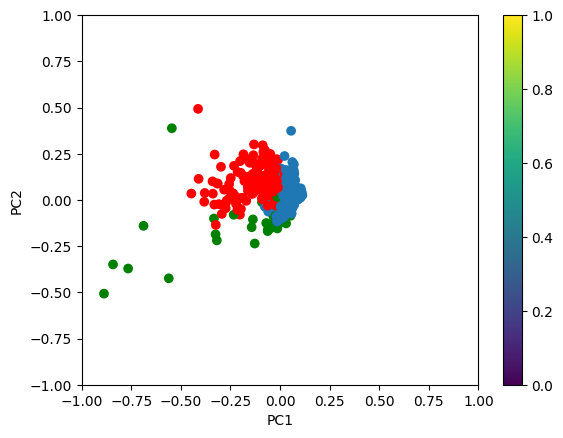

In [373]:
def myplot(ix, score, coeff, labels=None):
    coeff = coeff.T
    xs = score[:, ix[0]]
    ys = score[:, ix[1]]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    fig, ax = plt.subplots()
    sc = ax.scatter(xs * scalex,ys * scaley, c = y)
    if labels is not False:
        for i in range(n):
            ax.arrow(0, 0, coeff[i, ix[0]], coeff[i, ix[1]], color = 'k',alpha = 0.5)
            if labels is None:
                ax.text(coeff[i, ix[0]]* 1.15, coeff[i, ix[1]] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
            else:
                ax.text(coeff[i, ix[0]]* 1.15, coeff[i, ix[1]] * 1.15, labels[i], color = 'k', ha = 'center', va = 'center')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("PC{}".format(ix[0]+1))
    ax.set_ylabel("PC{}".format(ix[1]+1))
    fig.colorbar(sc)
    return fig, ax

ix = (0, 1)

y = ['C0' for x in target_df['Probe class']]
# y = ['C0' if x == 1 else 'r' for x in target_df['Probe class']]
y = ['C0' if x == 1 else 'g' if x == 0 else 'r' for x in target_df['Probe class']]
# y = target_df['Probe diff']
# y = target_df['Mean radius']
fig, ax = myplot(ix,
        X_pca,
       pca.components_,
    #    labels=input_df.columns,
       labels=False,
       )


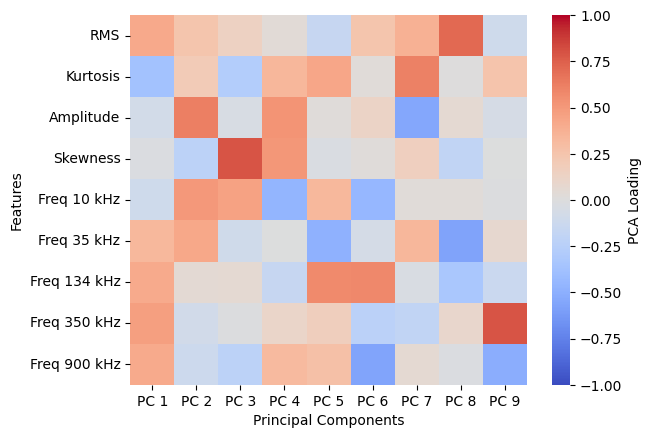

In [347]:
# Display which input features contribute most to the first principal component

# Dataframe to store the contribution of each feature for the PC
df = pd.DataFrame(pca.components_.T,
                  index=input_df.columns,
                  columns=[f'PC {i+1}' for i in range(pca.components_.shape[0])]
                  )

fig, ax = plt.subplots(1, 1)
ax = sns.heatmap(df,
                 annot=False,
                 fmt='.2f',
                 ax=ax,
                 vmin=-1,
                 vmax=1,
                 cbar_kws={'label': 'PCA Loading'},
                 cmap='coolwarm',
                 )
ax.set_xlabel('Principal Components')
ax.set_ylabel('Features');


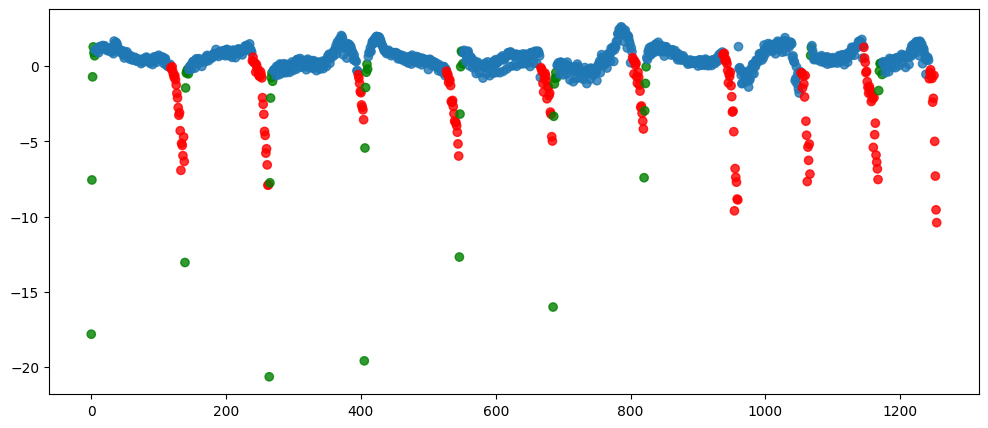

In [366]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

c = ['C0' if x == 1 else 'r' if x == 2 else 'g' for x in target_df['Probe class']]
# c  = ['C0' if x == 0 else 'r' for x in target_df['Probe class']] 

ax.scatter(x=target_df.index, y=X_pca[:, 0], c=c, alpha=0.8)
# ax[1].plot(target_df['Probe diff'], 'o')
